In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# !unzip gdrive/My\ Drive/data/dataset.zip > /dev/null

In [3]:
# Import Libraries

import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# Read image paths

imagePaths=[]
for root, dirnames, filenames in os.walk(r'../dataset'):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
            imagePaths.append(os.path.join(root, filename))
            
print(len(imagePaths))

25260


In [5]:
image=plt.imread(imagePaths[0])
image.shape

(128, 64, 3)

In [6]:
# AutoEncoder

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape

input_shape=(128, 64, 3)
encoding_dim = 32

# Encoder
encoder = Sequential([
    Flatten(input_shape=input_shape),
    Dense(4096, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(encoding_dim, activation='relu')
])

# Decoder
decoder = Sequential([
    Dense(128, activation='relu', input_shape=(encoding_dim,)),
    Dense(256, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(128 * 64 * 3, activation='sigmoid'),
    Reshape((128, 64, 3)),
])

autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(loss = 'mse')

In [7]:
autoencoder_dr.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (InputLayer)  [(None, 128, 64, 3)]      0         
                                                                 
 flatten (Flatten)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 4096)              100667392 
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dense_4 (Dense)             (None, 128)               32896 

In [8]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 1024)              263168    
                                                                 
 dense_9 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_10 (Dense)            (None, 4096)              8392704   
                                                                 
 dense_11 (Dense)            (None, 24576)             100687872 
                                                                 
 reshape (Reshape)           (None, 128, 64, 3)       

In [9]:
# Compile the model

autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(loss = 'mse')

In [10]:
#Early Sopping

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [11]:
from sklearn.model_selection import train_test_split

# Test Train Split

imagePathsTrain, imagePathsTest = train_test_split(imagePaths, test_size=0.1, random_state=42)
print(len(imagePathsTrain), len(imagePathsTest))

22734 2526


In [12]:
x_train = []
x_val = []
train = []

for i in range(len(imagePathsTrain)):
  if i%7000 == 0 and i!=0:
    # Train the autoencoder
    x_train, x_val = train_test_split(train, test_size=0.2, random_state=42)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    print(np.array(train).shape, x_train.shape, x_val.shape, i)
    autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_val, x_val), callbacks=[es])
    train = []
    x_train = []
    x_val = []
  try:
    # Process the images
    image=plt.imread(imagePaths[i])
    image = image/255
    train.append(image)
  except:
    pass
x_train, x_val = train_test_split(train, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_val = np.array(x_val)
print(np.array(train).shape, x_train.shape, x_val.shape)
autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_val, x_val))

(7000, 128, 64, 3) (5600, 128, 64, 3) (1400, 128, 64, 3) 7000
Epoch 1/100
88/88 [==============================] - 15s 62ms/step - loss: 0.0541 - val_loss: 0.0539
Epoch 2/100
88/88 [==============================] - 5s 57ms/step - loss: 0.0538 - val_loss: 0.0527
Epoch 3/100
88/88 [==============================] - 6s 68ms/step - loss: 0.0469 - val_loss: 0.0431
Epoch 4/100
88/88 [==============================] - 4s 49ms/step - loss: 0.0425 - val_loss: 0.0408
Epoch 5/100
88/88 [==============================] - 4s 49ms/step - loss: 0.0411 - val_loss: 0.0400
Epoch 6/100
88/88 [==============================] - 5s 52ms/step - loss: 0.0398 - val_loss: 0.0394
Epoch 7/100
88/88 [==============================] - 4s 49ms/step - loss: 0.0397 - val_loss: 0.0395
Epoch 8/100
88/88 [==============================] - 4s 49ms/step - loss: 0.0392 - val_loss: 0.0390
Epoch 9/100
88/88 [==============================] - 5s 57ms/step - loss: 0.0388 - val_loss: 0.0393
Epoch 10/100
88/88 [=================

In [ ]:
# Save model
autoencoder_dr.save("autoencoder.h5")

In [ ]:
encoder.save("encoder.h5")
decoder.save("decoder.h5")

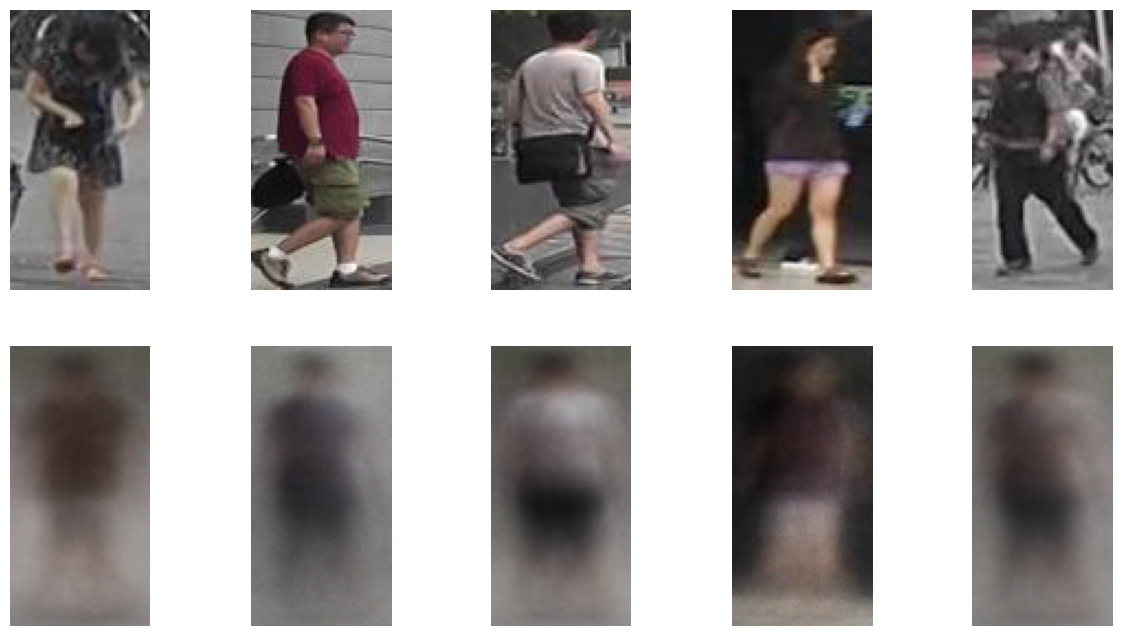

In [13]:
# Test images

x_test=[]
for i in range(len(imagePathsTest)):
  image=plt.imread(imagePaths[i])
  image = image/255
  x_test.append(image)
x_test=np.array(x_test)

reconstructed_img = autoencoder_dr(x_test[0:5])

f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(x_test[j], cmap='binary')
    axs[1, j].imshow(reconstructed_img[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [ ]:
fp = open("autoencoder_features.txt", "w")
for i in imagePaths:
  try:
    image=plt.imread(i)
    image = image/255
    fp.write(i+","+",".join(map(str, encoder(np.array([image])).numpy()[0].tolist()))+"\n")
  except:
    pass
fp.close()

In [ ]:
# !wc -l /content/gdrive/MyDrive/data/autoencoder_features.txt

25259 /content/gdrive/MyDrive/data/autoencoder_features.txt


In [ ]:
# Read feature files

image_path = []
image_features = []
fp = open("autoencoder_features.txt", "r")
for line in fp:
  line = line.strip()
  image_path.append(line.split(",")[0].split("/")[1].split(",")[0])
  image_features.append(list(map(float, line.split(",")[1:])))

In [ ]:
image_features = np.array(image_features)
image_features.shape

(25259, 32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[12393230.444797646, 10819230.629646448, 9749997.364210622, 9230119.171309162, 8867472.427741729, 8580470.168569613, 8374138.963003743, 8205022.642127359, 8051924.676859043, 7916607.109283774, 7804412.769522946, 7510700.902690948, 7300792.216218216, 7062307.19897593, 6832106.878559915, 6651059.269075386, 6491630.205482741, 6357993.66504799, 6233689.008124445]


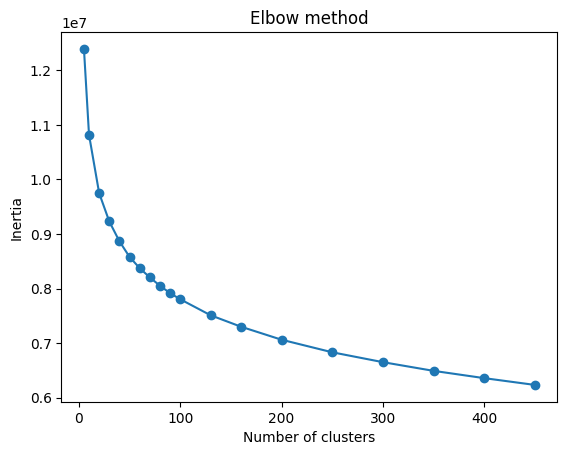

In [ ]:
# Cluster Extracted Features KMEans

from sklearn.cluster import KMeans

inertias = []
cluster_list = [5,10,20,30,40,50,60,70,80,90,100,130,160,200,250,300,350,400,450]
for i in cluster_list:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(image_features)
    inertias.append(kmeans.inertia_)

print(inertias)

plt.plot(cluster_list, inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()